# RNN Evaluation

In [1]:
import sys
import os
from pathlib import Path

wd = Path(os.path.dirname(os.path.abspath("__file__"))).parent.resolve()
sys.path.append(str(wd))

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from datetime import datetime, timedelta
from prediction_engine.model import AuctionPredictor

pd.options.display.max_columns = None
pd.options.display.width = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
prediction_time = datetime.strptime("2024-10-12 00:00:00", "%Y-%m-%d %H:%M:%S")

items = pd.read_csv('../data/items.csv')
print("Items shape:", items.shape)

n_items = len(items)
item_to_index = {item_id: i + 2 for i, item_id in enumerate(items['item_id'])}
item_to_index[0] = 0
item_to_index[1] = 1
print(f"Number of unique items: {n_items}")

time_left_mapping = {
    'VERY_LONG': 48,
    'LONG': 12,
    'MEDIUM': 2,
    'SHORT': 0.5
}

Items shape: (11655, 13)
Number of unique items: 11655


In [3]:
def load_auctions_from_sample(data_dir, prediction_time):
    file_info = {}
    auction_appearances = {}

    for root, dirs, files in os.walk(data_dir):
        for filename in tqdm(files):
            filepath = os.path.join(root, filename)
            date = datetime.strptime(filename.split('.')[0], '%Y%m%dT%H')
            file_info[filepath] = date

    file_info = {k: v for k, v in sorted(file_info.items(), key=lambda item: item[1])}
    
    raw_auctions = []
    
    for filepath in list(file_info.keys()):
        with open(filepath, 'r') as f:
            try:
                json_data = json.load(f)
                
                if 'auctions' not in json_data:
                    print(f"File {filepath} does not contain 'auctions' key, skipping.")
                    continue
                
                auction_data = json_data['auctions']
                timestamp = file_info[filepath]
                
                for auction in auction_data:
                    auction_id = auction['id']

                    if auction_id not in auction_appearances:
                        auction_appearances[auction_id] = {'first': timestamp, 'last': timestamp}
                    else:
                        auction_appearances[auction_id]['last'] = timestamp
                
                if prediction_time is not None:
                    if timestamp == prediction_time:
                        raw_auctions.extend(auction_data)
                else:
                    raw_auctions.extend(auction_data)

            except json.JSONDecodeError as e:
                print(f"Error loading file {filepath}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error loading file {filepath}: {e}")
                continue

    auctions = []
    for auction in tqdm(raw_auctions):
        first_appearance = auction_appearances[auction['id']]['first']
        last_appearance = auction_appearances[auction['id']]['last']

        auctions.append([
            auction['id'],
            auction['item']['id'],
            auction['bid'] / 10000.0,
            auction['buyout'] / 10000.0,
            auction['quantity'],
            auction['time_left'],
            first_appearance.strftime('%Y-%m-%d %H:%M:%S'),
            last_appearance.strftime('%Y-%m-%d %H:%M:%S')
        ])
        
    df_auctions = pd.DataFrame(auctions, columns=['id', 'item_id', 'bid', 'buyout', 'quantity', 'time_left', 'first_appearance', 'last_appearance'])
    df_auctions['first_appearance'] = pd.to_datetime(df_auctions['first_appearance'])
    df_auctions['last_appearance'] = pd.to_datetime(df_auctions['last_appearance'])

    df_auctions = df_auctions[(df_auctions['first_appearance'] <= prediction_time) & (df_auctions['last_appearance'] >= prediction_time)]

    df_auctions['hours_since_first_appearance'] = (prediction_time - df_auctions['first_appearance']).dt.total_seconds() / 3600
    df_auctions['hours_on_sale'] = (df_auctions['last_appearance'] - prediction_time).dt.total_seconds() / 3600

    return df_auctions

data_dir = '../data/sample/'

df_auctions = load_auctions_from_sample(data_dir, prediction_time)
df_items = pd.read_csv('../data/items.csv')

df_auctions = df_auctions.merge(df_items, left_on='item_id', right_on='item_id', how='left')

print("Auctions shape:", df_auctions.shape)
df_auctions.head()

0it [00:00, ?it/s]
100%|██████████| 6302/6302 [00:00<00:00, 238102.78it/s]

Auctions shape: (6302, 22)


,id,item_id,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,item_name,quality,item_level,required_level,item_class,item_subclass,purchase_price_gold,purchase_price_silver,sell_price_gold,sell_price_silver,max_count,is_stackable
0,1408614535,15279,9.5000,10.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Ivory Wand,Uncommon,51.0,46.0,Weapon,Wand,9.0,13.0,1.0,82.0,0.0,0.0
1,1408614543,15294,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Siege Bow,Uncommon,53.0,48.0,Weapon,Bow,10.0,6.0,2.0,1.0,0.0,0.0
2,1408614547,10070,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Armor,Uncommon,55.0,50.0,Armor,Leather,7.0,74.0,1.0,54.0,0.0,0.0
3,1408614554,10075,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Spaulders,Uncommon,51.0,46.0,Armor,Leather,4.0,68.0,0.0,93.0,0.0,0.0
4,1408614562,10078,42.7501,45.0001,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Lord's Crest,Uncommon,53.0,48.0,Armor,Shield,9.0,32.0,1.0,86.0,0.0,0.0


In [4]:
df_auctions[['hours_since_first_appearance', 'hours_on_sale']].describe()

,hours_since_first_appearance,hours_on_sale
count,6302.000000,6302.000000
mean,22.865757,20.035386
std,15.159400,14.166070
min,0.000000,0.000000
25%,10.000000,9.000000
50%,24.000000,18.000000
75%,34.000000,25.000000
max,48.000000,50.000000


In [9]:
model = AuctionPredictor(
    n_items=len(item_to_index),             
    input_size=5,                   
    encoder_hidden_size=2048,
    decoder_hidden_size=2048,
    num_layers=3,
    item_index=3,                   
    embedding_size=1024,
    dropout_p=0.2,
    bidirectional=False
).to(device)

print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

model_path = '../models/checkpoint_epoch_0_iter_51115.pt'
checkpoint = torch.load(model_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  
print('Pre-trained RNN model loaded successfully.')

Number of model parameters: 156746753
Pre-trained RNN model loaded successfully.


In [10]:
@torch.no_grad()
def predict(model, df_auctions, prediction_time, lambda_value=0.0401, device='cpu'):
    model.eval()

    auctions_by_item = {}

    for group_item_id in tqdm(df_auctions['item_id'].unique()):

        auctions_by_item[group_item_id] = []
        df_auctions_group = df_auctions[df_auctions['item_id'] == group_item_id]

        for index, auction in df_auctions_group.iterrows():
            auction_id = auction['id']
            item_id = auction['item_id']
            time_left_numeric = time_left_mapping.get(auction['time_left'], 0) / 48.0
            bid = np.log1p(auction['bid']) / 15.0
            buyout = np.log1p(auction['buyout']) / 15.0
            quantity = auction['quantity'] / 200.0
            item_index = item_to_index.get(item_id, 1)
            hours_since_first_appearance = auction['hours_since_first_appearance'] / 48.0

            processed_auction = [
                auction_id,
                bid, 
                buyout,  
                quantity, 
                item_index,
                time_left_numeric, 
                hours_since_first_appearance
            ]
            
            auctions_by_item[group_item_id].append(processed_auction)

    df_auctions['prediction'] = 0.0
    df_auctions['sale_probability'] = 0.0

    for group_item_id in tqdm(list(auctions_by_item.keys())):
        auction_data = np.array(auctions_by_item[group_item_id])

        X = torch.tensor(auction_data[:, 1:], dtype=torch.float32).to(device)
        lengths = torch.tensor([len(auction_data)])
        y = model(X.unsqueeze(0), lengths)

        for i, auction_id in enumerate(auction_data[:, 0]):
            df_auctions.loc[df_auctions['id'] == auction_id, 'prediction'] = round(y[0][i].item(), 2)
            df_auctions.loc[df_auctions['id'] == auction_id, 'sale_probability'] = np.exp(-lambda_value * y[0][i].item())

    return df_auctions

df_auctions = predict(model, df_auctions, prediction_time, device=device)

print("Mean hours on sale:", df_auctions['hours_on_sale'].mean())
print("Mean prediction:", df_auctions['prediction'].mean())
print("Mean sale probability:", df_auctions['sale_probability'].mean())

df_auctions.head()

100%|██████████| 1302/1302 [00:15<00:00, 84.08it/s] 

Mean hours on sale: 20.035385591875595
Mean prediction: 19.330182481751823
Mean sale probability: 0.51416477957295


,id,item_id,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,item_name,quality,item_level,required_level,item_class,item_subclass,purchase_price_gold,purchase_price_silver,sell_price_gold,sell_price_silver,max_count,is_stackable,prediction,sale_probability
0,1408614535,15279,9.5000,10.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Ivory Wand,Uncommon,51.0,46.0,Weapon,Wand,9.0,13.0,1.0,82.0,0.0,0.0,1.39,0.945849
1,1408614543,15294,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Siege Bow,Uncommon,53.0,48.0,Weapon,Bow,10.0,6.0,2.0,1.0,0.0,0.0,1.61,0.937594
2,1408614547,10070,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Armor,Uncommon,55.0,50.0,Armor,Leather,7.0,74.0,1.0,54.0,0.0,0.0,1.81,0.930138
3,1408614554,10075,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Spaulders,Uncommon,51.0,46.0,Armor,Leather,4.0,68.0,0.0,93.0,0.0,0.0,1.77,0.931440
4,1408614562,10078,42.7501,45.0001,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Lord's Crest,Uncommon,53.0,48.0,Armor,Shield,9.0,32.0,1.0,86.0,0.0,0.0,1.83,0.929165


In [11]:
mae = mean_absolute_error(df_auctions['hours_on_sale'], df_auctions['prediction'])
print(f"Mean absolute error: {mae}")

Mean absolute error: 4.134457315138052


## Error analysis

In [12]:
columns = [
    'item_name',
    'bid',
    'buyout',
    'quantity',
    'time_left',
    'first_appearance',
    'last_appearance',
    'hours_since_first_appearance',
    'hours_on_sale',
    'prediction',
    'sale_probability'
]

df_error = df_auctions[columns].copy()
df_error['error'] = np.abs(df_error['hours_on_sale'] - df_error['prediction'])
df_error['time_left'] = df_error['time_left'].map(time_left_mapping)

df_error.head()

,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
0,Ivory Wand,9.5000,10.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.39,0.945849,0.61
1,Siege Bow,42.7500,45.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.61,0.937594,0.39
2,Righteous Armor,42.7500,45.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.81,0.930138,0.19
3,Righteous Spaulders,42.7500,45.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.77,0.931440,0.23
4,Lord's Crest,42.7501,45.0001,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.83,0.929165,0.17


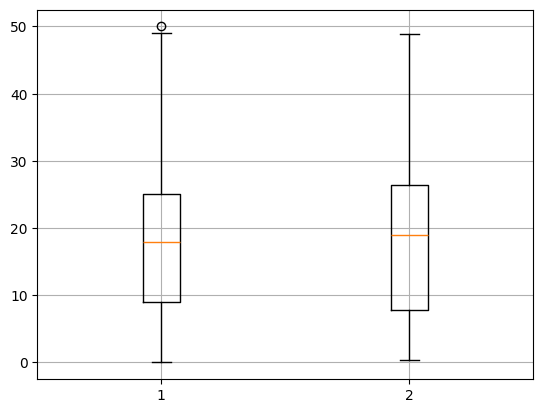

In [13]:
plt.boxplot(df_error[['hours_on_sale', 'prediction']])
plt.grid()
plt.show()

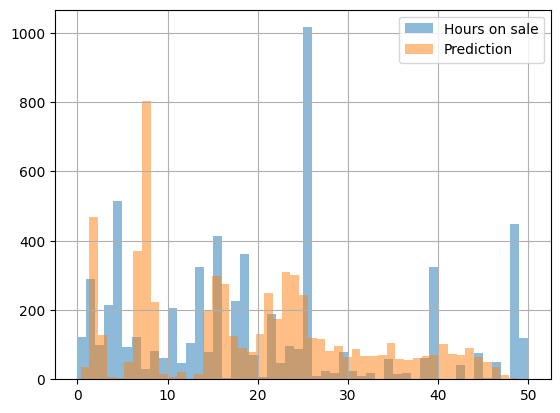

In [20]:
# histogram of hours on sale and prediction
plt.hist(df_error['hours_on_sale'], bins=50, alpha=0.5, label='Hours on sale')
plt.hist(df_error['prediction'], bins=50, alpha=0.5, label='Prediction')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [14]:
df_error[df_error['hours_on_sale'] <= 10].sample(10)

,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
4834,Tin Ore,0.0750,10.0000,20,48.0,2024-10-11 20:00:00,2024-10-12 05:00:00,4.0,5.0,17.88,0.488217,12.88
3246,Ravencrest Legplates,19.5516,25.0000,1,2.0,2024-10-11 02:00:00,2024-10-12 03:00:00,22.0,3.0,1.76,0.931793,1.24
5883,"Basilisk ""Liver""",15.0978,15.8924,4,0.5,2024-10-11 12:00:00,2024-10-12 01:00:00,12.0,1.0,2.14,0.917594,1.14
3463,Heartblossom,42.5100,42.5980,20,12.0,2024-10-11 05:00:00,2024-10-12 06:00:00,19.0,6.0,7.17,0.750191,1.17
665,Glyph of Rake,145.0150,145.9900,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,7.63,0.736355,3.63
5950,Righteous Orb,47.4993,49.9992,2,0.5,2024-10-11 00:00:00,2024-10-12 01:00:00,24.0,1.0,2.94,0.888876,1.94
3215,Draught of War,17.9438,18.8882,1,2.0,2024-10-11 02:00:00,2024-10-12 03:00:00,22.0,3.0,2.11,0.918929,0.89
302,Glyph of Unbreakable Armor,9.9899,9.9899,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,8.13,0.721673,4.13
3500,Inferno Ruby,167.0000,168.8800,1,12.0,2024-10-11 05:00:00,2024-10-12 06:00:00,19.0,6.0,7.76,0.732575,1.76
468,Glyph of the Wild,230.9999,230.9999,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,7.40,0.743147,3.40


In [17]:
df_error[df_error['hours_on_sale'] > 30].sample(10)

,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
6070,Glyph of Bestial Wrath,554.0150,555.0000,1,48.0,2024-10-12 00:00:00,2024-10-14 01:00:00,0.0,49.0,40.11,0.200217,8.89
4165,Glyph of Voidwalker,15.6556,15.6556,1,48.0,2024-10-11 14:00:00,2024-10-13 15:00:00,10.0,39.0,33.85,0.257328,5.15
5697,Splinterspear Knuckles,19.0000,20.0000,1,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,37.27,0.224314,10.73
4058,Poached Nettlefish,60.8000,64.0000,20,48.0,2024-10-11 13:00:00,2024-10-13 14:00:00,11.0,38.0,22.28,0.409254,15.72
4410,Glyph of Sap,79.7900,79.7900,1,48.0,2024-10-11 14:00:00,2024-10-13 15:00:00,10.0,39.0,30.24,0.297405,8.76
5097,Glyph of Deterrence,24.6991,25.9990,1,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,40.38,0.198045,7.62
5255,Ghost Elixir,339.8872,357.7760,20,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,39.77,0.202970,8.23
5181,Zen Dream Emerald,116.2775,122.3973,1,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,28.85,0.314437,19.15
4326,Glyph of Succubus,330.9999,330.9999,1,48.0,2024-10-11 14:00:00,2024-10-13 15:00:00,10.0,39.0,38.02,0.217734,0.98
4372,Glyph of Hungering Cold,322.9999,322.9999,1,48.0,2024-10-11 14:00:00,2024-10-13 15:00:00,10.0,39.0,35.81,0.237868,3.19


In [ ]:
sns.pairplot(df_error[['buyout', 'time_left', 'hours_since_first_appearance', 'hours_on_sale', 'prediction', 'error']])

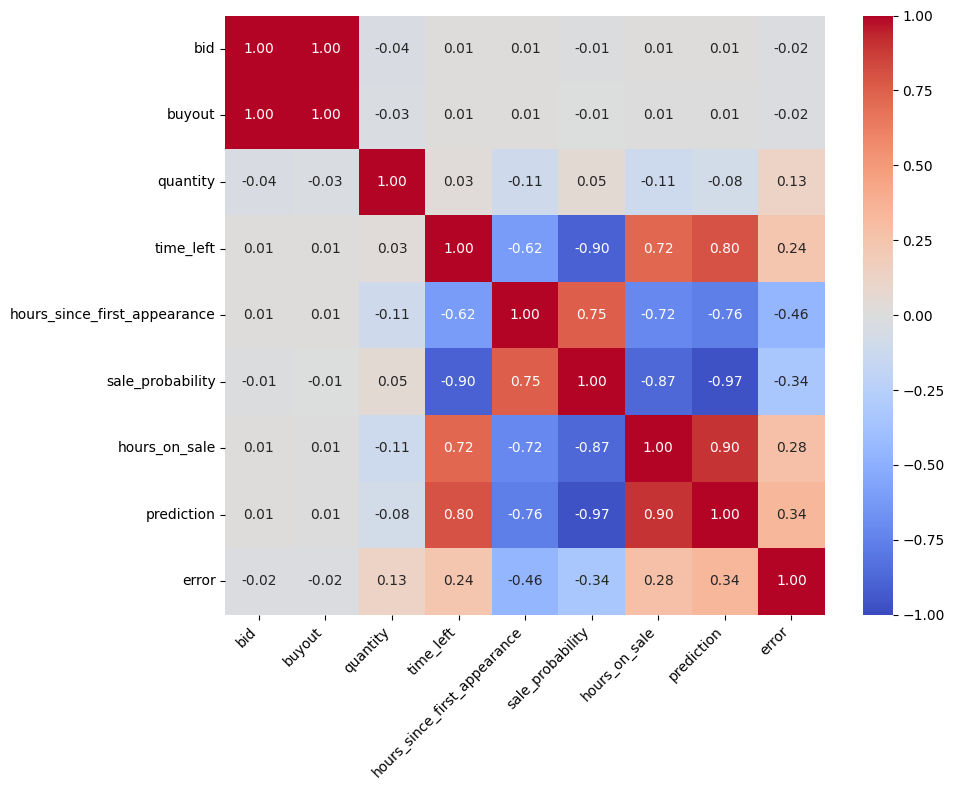

In [21]:
corr_matrix = df_error[['bid', 'buyout', 'quantity', 'time_left', 'hours_since_first_appearance', 'sale_probability',
                        'hours_on_sale', 'prediction', 'error']].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1, 
            center=0,
            fmt='.2f',
            square=True) 

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

In [ ]:
df_error.to_csv('../generated/predictions.csv')